In [5]:
#importing the basic datasets
import numpy as np
import pandas as pd
from numpy import array, argmax, random, take

import string
import re
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
%matplotlib inline
pd.set_option('display.max_colwidth', 200)


In [6]:
data_path = 'deu.txt'

In [7]:
df = pd.read_csv(data_path, delimiter= '\t')

In [8]:
df.head()

,Hi.,Hallo!,CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)
0,Hi.,Grüß Gott!,CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)
1,Run!,Lauf!,CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)
2,Wow!,Potzdonner!,CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)
3,Wow!,Donnerwetter!,CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)
4,Fire!,Feuer!,CC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #1958697 (Tamy)


In [9]:
df1 = df.iloc[:,0:2]
df1.head()

,Hi.,Hallo!
0,Hi.,Grüß Gott!
1,Run!,Lauf!
2,Wow!,Potzdonner!
3,Wow!,Donnerwetter!
4,Fire!,Feuer!


In [10]:
#change dataframe into array
data_arr= df1.values
data_arr[:50000,:]

array([['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ['Wow!', 'Potzdonner!'],
       ...,
       ['He has only four pesos.', 'Er hat nur vier Pesos.'],
       ['He has stopped smoking.', 'Er hörte mit dem Rauchen auf.'],
       ['He has stopped smoking.', 'Er hat mit dem Rauchen aufgehört.']],
      dtype=object)

In [11]:
#remove punctuation
data_arr[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in data_arr[:,0]]
data_arr[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in data_arr[:,1]]
data_arr

array([['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ['Wow', 'Potzdonner'],
       ...,
       ['If someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker In other words you dont really sound like a native speaker',
        'Wenn jemand Fremdes dir sagt dass du dich wie ein Muttersprachler anhörst bedeutet das wahrscheinlich Er hat etwas an deinem Sprechen bemerkt dass dich als NichtMuttersprachler verraten hat Mit anderen Worten Du hörst dich nicht wirklich wie ein Muttersprachler an'],
       ['It may be impossible to get a completely errorfree corpus due to the nature of this kind of collaborative effort However if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning we might be able to minimize errors',
        'Es ist wohl unmöglich einen vollkommen fehlerfreien Korpus z

In [12]:
# convert text to lowercase
for i in range(len(data_arr)):
    data_arr[i,0] = data_arr[i,0].lower()
    data_arr[i,1] = data_arr[i,1].lower()

data_arr

array([['hi', 'grüß gott'],
       ['run', 'lauf'],
       ['wow', 'potzdonner'],
       ...,
       ['if someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker in other words you dont really sound like a native speaker',
        'wenn jemand fremdes dir sagt dass du dich wie ein muttersprachler anhörst bedeutet das wahrscheinlich er hat etwas an deinem sprechen bemerkt dass dich als nichtmuttersprachler verraten hat mit anderen worten du hörst dich nicht wirklich wie ein muttersprachler an'],
       ['it may be impossible to get a completely errorfree corpus due to the nature of this kind of collaborative effort however if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning we might be able to minimize errors',
        'es ist wohl unmöglich einen vollkommen fehlerfreien korpus z

In [13]:
# empty lists
eng_l = []
deu_l = []

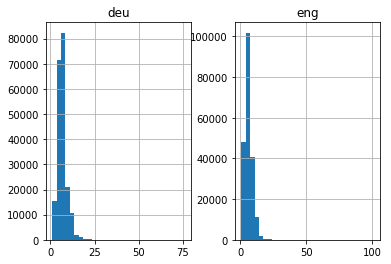

In [14]:
#working with the length of sentences

for i in data_arr[:,0]:
      eng_l.append(len(i.split()))

for i in data_arr[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [15]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [16]:
# prepare english tokenizer
eng_tokenizer = tokenization(data_arr[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 16380


In [17]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(data_arr[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 35442


In [18]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [19]:
#model building

from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(data_arr, test_size=0.2, random_state = 12)

In [20]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [21]:
# build model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [22]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [23]:
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=10, batch_size=512, validation_split = 0.2, 
                    verbose=1)

Train on 130926 samples, validate on 32732 samples
Epoch 1/10
130926/130926 [==============================] - 2279s 17ms/step - loss: 4.9203 - val_loss: 4.5614
Epoch 2/10
130926/130926 [==============================] - 2971s 23ms/step - loss: 4.3336 - val_loss: 4.1806
Epoch 3/10
130926/130926 [==============================] - 2166s 17ms/step - loss: 3.9119 - val_loss: 3.7593
Epoch 4/10
130926/130926 [==============================] - 2197s 17ms/step - loss: 3.5062 - val_loss: 3.4017
Epoch 5/10
130926/130926 [==============================] - 2957s 23ms/step - loss: 3.1417 - val_loss: 3.1325
Epoch 6/10
130926/130926 [==============================] - 64114s 490ms/step - loss: 2.8369 - val_loss: 2.8976
Epoch 7/10
130926/130926 [==============================] - 2304s 18ms/step - loss: 2.5881 - val_loss: 2.7581
Epoch 8/10
130926/130926 [==============================] - 2274s 17ms/step - loss: 2.3790 - val_loss: 2.6341
Epoch 9/10
130926/130926 [==============================] - 2225s 1

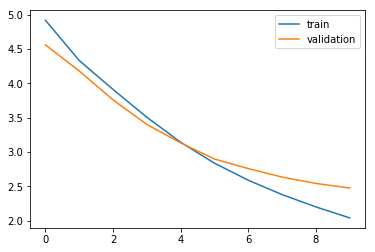

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [25]:
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [26]:
accuracy_score(testX[0], testX[1], normalize=False)

1